## Data

We will use data from USA only

We use the 153 characteristics used by JKP

We will use Kenneth French's industry portfolios

In [ ]:
import pandas as pd
import numpy as np
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets
from datetime import datetime
import matplotlib.pyplot as plt
from utils_new import demarket, regcov, l2est
from cross_validate import cross_validate
import yfinance as yf
import glmnet_python
from glmnet import glmnet
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings("ignore")  # Ignorerer alle advarsler


import matplotlib.tri as tri


from sklearn.model_selection import train_test_split, GridSearchCV

data = pd.read_csv("C:/Users/ulrik/Downloads/[usa]_[all_factors]_[monthly]_[vw_cap].csv")

#Get unique values
unique_values = data.iloc[:, 1].unique()


data["date"] = pd.to_datetime(data["date"])
data = data[data["date"] >= "1980-01-01"]
data["date"] = data["date"].dt.strftime("%Y-%m")

data
ff_dict = FamaFrenchReader('10_Industry_Portfolios',
                           start='1980-01-01', 
                           end='2023-12-31').read()

ff_dict_returns = ff_dict[1] / 100
data_short = data[['name', 'date', 'ret']]

df = pd.DataFrame(data)


df['date'] = pd.to_datetime(df['date'])

df_wide = df.pivot(index='date', columns='name', values='ret')


SPX = data = pd.read_csv("C:/Users/ulrik/Downloads/S&P 500 Historical Data.csv")

SPX['Date'] = pd.to_datetime(SPX['Date'], format='%m/%d/%Y')  # Adjust format if needed

# Set 'Date' as index and keep only 'Change %' column
SPX = SPX.set_index('Date')[['Change %']]
SPX = SPX.iloc[::-1]

SPX['Change %'] = SPX['Change %'].str.rstrip('%').astype(float) / 100

from fredapi import Fred
import pandas_datareader.data as web



# Define the time range
start_date = "1980-01-01"
end_date = "2023-12-01"

# Fetch 1-month Treasury bill rate from FRED
t_bill_monthly = web.DataReader('DGS1', 'fred', start_date, end_date)

# Resample to monthly frequency (if needed)
t_bill_monthly = t_bill_monthly.resample('M').last()


t_bill_monthly = (1 + t_bill_monthly / 100) ** (1 / 12) - 1

# Ensure the index is in datetime format
t_bill_monthly.index = pd.to_datetime(t_bill_monthly.index)

# Convert end-of-month dates to start-of-month
t_bill_monthly.index = t_bill_monthly.index.to_period("M").to_timestamp(how="start")

merged_df = pd.concat([SPX, t_bill_monthly], axis=1)
merged_df['mkt_er'] = merged_df['Change %'] - merged_df['DGS1']

mkt_er = merged_df[['mkt_er']]
mkt_er_1 = mkt_er['mkt_er']
SPX_1 = SPX.squeeze()
excess_factor_returns = demarket(df_wide, SPX_1)
excess_factor_returns = excess_factor_returns[0]

# Daily Data

In [3]:

# Load dataset
daily_data = pd.read_csv("C:/Users/ulrik/Downloads/[usa]_[all_factors]_[daily]_[vw_cap].csv")

# Convert "date" to datetime format
daily_data["date"] = pd.to_datetime(daily_data["date"])

# Filter dates (ensures no formatting issue)
daily_data = daily_data[daily_data["date"] >= "1980-01-01"]

# Keep only the relevant columns
df_daily = daily_data[['name', 'date', 'ret']].copy()

# Ensure there are NO duplicate (date, name) pairs
df_daily = df_daily.sort_values(by=['date', 'name']).drop_duplicates(subset=['date', 'name'])

# Set "date" as the index (keeps daily frequency)
df_daily.set_index(['date', 'name'], inplace=True)

# Unstack instead of pivoting (since date is already the index)
df_daily = df_daily.unstack(level=1)

# Remove extra column level for clean format
df_daily.columns = df_daily.columns.droplevel()

# Ensure 'date' index is in datetime format
df_daily.index = pd.to_datetime(df_daily.index)

# Filter the DataFrame to start 
df_daily = df_daily.loc['1990-01-02':'2023-12-31']


# Download S&P 500 data (SPX) from Yahoo Finance
spx = yf.download("^GSPC", start="1990-01-01", end="2023-12-31", interval="1d")

# Select only the 'Close' price
spx = spx[['Close']].rename(columns={'Close': 'SPX'})  # Rename for clarity

# Calculate daily returns
spx_daily_ret = spx['SPX'].pct_change()  # Convert to %

# Drop first NaN value (caused by pct_change)
spx_daily_ret.dropna(inplace=True)

# Ensure both indices are in datetime format
spx_daily_ret.index = pd.to_datetime(spx_daily_ret.index)
df_daily.index = pd.to_datetime(df_daily.index)

# Find the common date range (intersection of indices)
common_dates = spx_daily_ret.index.intersection(df_daily.index)

# Filter both DataFrames to only include the common dates
spx_daily_ret = spx_daily_ret.loc[common_dates]
df_daily = df_daily.loc[common_dates]

daily_unique_values = daily_data.iloc[:, 1].unique() 

spx_daily_ret_squeezed = spx_daily_ret.squeeze()
df_daily_squeezed = df_daily.squeeze()

daily_date_series = pd.Series(df_daily.index)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Visuals

In [4]:
def plot_dof(df, x, p):
    """
    degrees of freedom <-> kappa plot
    
    Parameters:
    - df: Degrees of freedom data to be plotted on the y-axis.
    - x: Data to be plotted on the x-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot
    plt.plot(x, df, linewidth=p['line_width'])
    
    # Log-scale adjustments
    if p['L1_log_scale']:
        plt.yscale('log')
        plt.yticks([tick + 1e-12 for tick in plt.yticks()[0]])  # Adding a small constant
    
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-12 for tick in plt.xticks()[0]])  # Adding a small constant
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel('Effective degrees of freedom', fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Setting x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/degrees_of_freedom.png', dpi=300, bbox_inches='tight')


def plot_L2coefpaths(x, phi, iL2opt, anomalies, ylbl, p):
    """
    L2 coefficients paths plot
    
    Parameters:
    - x: Data for the x-axis.
    - phi: Coefficient path data.
    - iL2opt: Optimal index for regularization.
    - anomalies: Names for legends.
    - ylbl: Label for the y-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Decide sorting location
    if p['L2_sort_loc'] == 'opt':
        iSortLoc = iL2opt
    elif p['L2_sort_loc'] == 'OLS':
        iSortLoc = 0
    else:
        raise ValueError('Unknown option')
    
    # Sorting mechanism
    if p['n'] > p['L2_max_legends']:
        I = np.argsort(-np.abs(phi[:, iSortLoc]))  # Descending sort by absolute value
    else:
        I = np.argsort(-phi[:, iSortLoc])  # Descending sort
    
    # Open a new figure
    plt.figure()
    
    # Plot
    for i in I:
        plt.plot(x, phi[i, :], linewidth=p['line_width'])
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(ylbl, fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Legend
    idx = I[:min(p['L2_max_legends'], len(I))]
    plt.legend([anomalies[i] for i in idx], loc=p['legend_loc'], fontsize=p['font_size'], bbox_to_anchor=(1.05, 1))
    
    # Dashed line at optimal regularization
    plt.plot([x[iL2opt], x[iL2opt]], [np.min(phi), np.max(phi)], '--k')
    
    # x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        if ylbl == 'SDF Coefficient, $b$':
            plt.savefig('results_export/coefficients_paths.png', dpi=300, bbox_inches='tight')
        elif ylbl == 'SDF Coefficient $t$-statistic':
            plt.savefig('results_export/tstats_paths.png', dpi=300, bbox_inches='tight')


def plot_L2cv(x, objL2, p):
    """
    Plot SSE/objective & BIC as a function of degrees of freedom.
    
    Parameters:
    - x: Data for the x-axis.
    - objL2: Data for plotting objectives and possible other values.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot In-sample (IS) and Out-of-Sample (OOS)
    plt.plot(x, objL2[:, 0], '--', linewidth=p['line_width'])  # IS
    plt.plot(x, objL2[:, 1], '-', linewidth=p['line_width'])  # OOS
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(f"IS/OOS {p['sObjective']}", fontsize=12, labelpad=10, fontweight='bold')
    
    # Legends and plot +1, -1 standard error
    co = plt.gca().lines[-1].get_color()  # Getting color of last line plotted (OOS line)
    plt.plot(x, objL2[:, 1] + objL2[:, 3], ':', color=co, linewidth=1)  # +1 SE
    plt.plot(x, objL2[:, 1] - objL2[:, 3], ':', color=co, linewidth=1)  # -1 SE
    
    plt.legend(['In-sample', f"OOS {p['method']}", f"OOS {p['method']} +/- 1 s.e."],
               loc='upper right')
    
    # Grid, axis limits
    plt.grid(True)
    plt.ylim([0, max(0.1, min(10, 2*max(objL2[:, 1])))])
    plt.xlim([min(x), 2])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/cross_validation.png', dpi=300, bbox_inches='tight')



def table_L2coefs(phi, se, anomalies, p):
    """
    Function to display a table of largest coefficients and t-stats.

    Parameters:
    - phi: Coefficients.
    - se: Standard error.
    - anomalies: Anomaly descriptions.
    - p: Dictionary containing various parameters.
    """
    nrows = 10  # number of rows in the table to show
    
    # t-stats
    tstats = phi / se
    
    # by absolute tstats
    idx = np.argsort(np.abs(tstats))[::-1]
    
    # show only nrows items
    idx = idx[:nrows]
   
    # create a DataFrame
    data = {
        'Portfolio': [anomalies[i] for i in idx],
        'b': phi[idx],
        't_stat': np.abs(tstats[idx])
    }
    df = pd.DataFrame(data)
    
    # display table
    print(df)

    # export as a latex formatted table
    if p['results_export']:
        df.to_latex('results_export/coefficients_table.tex', index=False)

# Fixes index and def FUN

In [5]:
ff_dict_returns.index = df_wide.index
# Generate monthly dates as a Pandas Series
date_series = pd.Series(pd.date_range(start="1980-01-01", end="2023-12-01", freq='MS'))



# Accessing both .iloc and .strftime()
print(date_series.iloc[-1])  # Extract the last date (2023-12-01)
print(date_series.iloc[-1].strftime('%Y-%m-%d'))  # Format the last date as a string
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_daily_scaled = pd.DataFrame(scaler.fit_transform(df_daily), 
                               index=df_daily.index, 
                               columns=df_daily.columns)


spx_daily_ret_scaled = pd.DataFrame(scaler.fit_transform(spx_daily_ret), 
                               index=spx_daily_ret.index, 
                               columns=spx_daily_ret.columns)

def cs_r2_metric(F, b):
    """
    Compute cross-sectional R^2 in the hold-out set:
      R^2 = 1 - [ (mu_test - Sigma_test*b)^T (mu_test - Sigma_test*b ) / mu_test^T mu_test ]
    """
    mu_test = F.mean(axis=0)               # (H,)
    Sigma_test = np.cov(F, rowvar=False)   # (H, H)
    pred_mean = Sigma_test @ b            # shape (H,)

    numerator = np.sum((mu_test - pred_mean)**2)
    denominator = np.sum(mu_test**2)
    return 1.0 - numerator / denominator


2023-12-01 00:00:00
2023-12-01


# Define function

In [6]:

def SCS_L2est(dates, re, market, freq, anomalies, parameters):
    """
    Computes the L2 shrinkage estimator of the SDF parameters
    based on the method in Kozak, Nagel, and Santosh (2019).
    
    Parameters:
    - dates (pd.Series): time series of dates
    - re (pd.DataFrame): matrix of excess returns time series
    - market (pd.Series): matrix of market's excess returns time series
    - freq (int): number of observations per year
    - anomalies (list): list of anomaly names
    - kwargs: other optional keyword arguments
        * gridsize (int): default=20
        * cvmethod (str): default='CV'
        * kfold (int): default=4
        * objective (str): default='C-S R^2'
        * plot_dof (bool): default=False
        * plot_coefpaths (bool): default=False
        * plot_objective (bool): default=False
        * ... more parameters...
    
    Returns:
    - estimates (dict): structure of estimates
    
    Note: Always cite the paper when using this function.
    """

    # Assign default values
    parameters = {
        'gridsize': 100,
        'method': 'CV',
        'objective': 'CSR2',
        'ignore_scale': False,
        'kfold': 3,
        'oos_test_date': dates.iloc[-500],
        'freq': freq,
        'rotate_PC': False,
        'demarket_conditionally': False,
        'demarket_unconditionally': True,
        'devol_conditionally': False,
        'devol_unconditionally': True,
        'plot_dof': True,
        'plot_coefpaths': True,
        'plot_objective': True,
        'line_width': 1.5,
        'font_size': 10,
        'L2_max_legends': 20,
        'L2_sort_loc': 'opt',
        'L1_log_scale': True,
        'L2_log_scale': True,
        'legend_loc': 'best',
        'results_export': True,
        'show_plot': False
    }

    # Parse config and assign default values
    # parameters = parse_config(parameters, default_config)

    # We usually maximize an objective (e.g., R^2), except for HJ-distance (GLS) and SSE
    if parameters["objective"] in ['GLS', 'SSE']:
        optfunc = min
    else:
        optfunc = max

    # User-friendly names for objectives to use in plots
    mapObj = {
        'CSR2': 'Cross-sectional $R^2$',
        'GLSR2': 'Cross-sectional GLS $R^2$',
        'GLS': 'Residual $SR^2$',
        'SRexpl': 'Explained SR',
        'SSE': 'SDF RMSE',
        'SR': 'Sharpe Ratio',
        'MVU': 'Mean-variance utility'
    }
    parameters["sObjective"] = mapObj[parameters["objective"]]

    # Initialize; compute means, cov, SVD decomposition
    # Testing sample start date
    tT0 = parameters["oos_test_date"]
    re.index = dates.values
    market.index = dates.values

    mkt0 = market.copy()

    # De-market all excess returns 
    if parameters['demarket_conditionally']:  # conditionally
        demarket_ma_window = 10 * parameters['freq']  # use past 3 years to estimate betas

        # Placeholder for custom function `demarkcond`
        r0 = demarketcond(re.iloc[idx_train, :], market.iloc[idx_train], demarket_ma_window)
        idx_train = idx_train[demarket_ma_window:]  # drop NaNs

    elif parameters['demarket_unconditionally']:  # unconditionally

        # Placeholder for custom function `demarket`
        r_train, b_train = demarket(re.loc[:tT0, :], market.loc[:tT0])
        r_test = demarket(re.loc[tT0:, :], market.loc[tT0:], b_train)  # use betas estimated in the training sample
        # check if r_test is a dataframe
        if isinstance(r_test, pd.DataFrame):
            r0 = pd.concat([r_train, r_test], axis=0)
        else:
            r0 = r_train.copy()

    else:
        r0 = re.copy()

    # De-vol all excess returns conditionally if requested
    if parameters['devol_conditionally']:
        devol_ma_window = 22  # use past 22 days to estimate volatilities

        # Placeholder for custom function `devolcond`
        r0, mkt0 = devolcond(r0, market, devol_ma_window)
        idx_train = idx_train[devol_ma_window:]  # drop NaNs

    elif parameters['devol_unconditionally']:  # de-vol unconditionally

        # Normalize so that all returns have the standard deviation of the VW market
        r0 = r0.divide(r0.std(axis=0), axis=1).multiply(market.std())

    # Construct dates, mkt, and returns for train and test sets
    mkt = mkt0.loc[:tT0]
    mkt_test = mkt0.loc[tT0:]

    r_train = r0.loc[:tT0, :]
    r_test = r0.loc[tT0:, :]

    # Length of the training sample
    T, n = r_train.shape
    parameters['T'] = T
    parameters['n'] = n

    # Rotate into PC space if requested and change file suffix
    if parameters.get('rotate_PC', False):
        # Use training sample to form eigenvectors
        _, _, Q = np.linalg.svd(np.cov(r_train, rowvar=False)) 
        r_train = np.dot(r_train, Q)
        r_test = np.dot(r_test, Q)
        anomalies = ['PC' + str(i) for i in range(1, n + 1)]

    # Compute first and second moments
    X = regcov(r_train)
    y = np.mean(r_train, axis=0)#.reshape(-1, 1)  # making y a column vector
    #X_test = regcov(r_test)  # TODO: test does not have data in it!!
    #y_test = np.mean(r_test, axis=0)#.reshape(-1, 1)  # making y_test a column vector

    # Maximum in-sample SR
    w = np.dot(np.dot(y.T, np.linalg.pinv(X)), y)
    maxSR2 = freq * w

    # Precompute E-V decomposition
    U, D, Q = np.linalg.svd(X)
    X2 = np.dot(np.dot(Q, np.sqrt(np.diag(D))), Q.T)
    d = np.sum(np.diag(D), axis=1)

    # Pre-compute pseudo inverses
    tol = max(X.shape) * np.finfo(float).eps * np.linalg.norm(d, np.inf)
    r1 = np.sum(d > tol) + 1
    Q1 = Q[:, :r1]
    s = d[:r1]
    s2 = 1 / np.sqrt(s)
    s = 1 / s
    Q1 = Q1.T
    Xinv = np.dot(Q1 * s.reshape(1, -1), Q1.T)
    X2inv = np.dot(Q1 * s2.reshape(1, -1), Q1.T)

    # Options
    parameters['xlbl'] = 'Root Expected SR$^2$ (prior), $\\kappa$'
    parameters['Q'] = Q
    parameters['d'] = d
    parameters['Xinv'] = Xinv


    # Functions to map L2pen <-> kappa
    kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)

    # Find left and right limits
    lr = np.arange(1, 22)  # equivalent of 1:21 in MATLAB
    lm = 1

    z = np.empty((n, len(lr)))
    z.fill(np.nan)

    for i in lr:
        params = parameters.copy()  # Make a copy of p to avoid modifying the original
        params['L2pen'] = kappa2pen(2 ** (i - lm), T, X, parameters)
        z[:, i - 1] = l2est(X, y, params)[0]

    # Coefficient stabilize condition
    mean_val = np.mean(np.abs((z[:, 1:] - z[:, :-1])) / (1 + np.abs(z[:, :-1])), axis=0) > 0.01
    x_rlim = np.nonzero(mean_val)[0]

    # Use the left and right points to define the support and create a finer grid on this support
    x = np.logspace(np.log10(2**x_rlim[-1]), np.log10(0.01), parameters['gridsize'])
    l = [kappa2pen(val, T, X, parameters) for val in x]
    lCV = [val / (1 - 1 / parameters['kfold']) for val in l]  
    nl = len(l)

    # Estimate the L2 model
    params = parameters.copy() # Make a copy of p to avoid modifying the original

    # Create placeholders for outputs
    phi = np.full((n, nl), np.nan)
    se = np.full_like(phi, np.nan)
    objL2 = np.full((nl, 4), np.nan)
    objL2_folds = np.full((nl, params['kfold']), np.nan)  # Assuming params['kfold'] is the number of folds
    MVE = [None] * nl

    for i in range(nl):
        print(i)
        # Estimate parameters at each grid point
        params['L2pen'] = l[i]
        # Note: You need to define the l2est function in Python or provide its MATLAB code for translation
        phi[:, i], _, se[:, i] = l2est(X, y, params, True)

        # Cross validate estimated parameters
        params['L2pen'] = lCV[i]
        # Note: You need to define the cross_validate function in Python or provide its MATLAB code for translation
        objL2[i, :], params, objL2_folds_ = cross_validate(l2est, dates.values, r_train, params)
        objL2_folds[i, :] = objL2_folds_[:, 1] # Python is 0-indexed

        # Store OOS MVE portfolios for each CV run
        MVE[i] = params['cv_MVE']

    cv_idx_test = params['cv_idx_test'] 

    # Effective degrees of freedom
    df = np.sum(d.reshape(153,1) / (d.reshape(153,1) + np.array(l).reshape(1,100)), axis=0)

    # Optimal L2 model
    
    objL2opt = optfunc(objL2[:, 1])
    if optfunc == max:
        iL2opt = objL2[:, 1].argmax()
    if optfunc == min:
        iL2opt = objL2[:, 1].argmin()
    bL2 = phi[:, iL2opt]
    parameters['bL2'] = bL2
    parameters['R2oos'] = objL2opt
    L2optKappa = x[iL2opt]

    # MVE portfolios for each fold at the optimal level of shrinkage [flatten into single time-series]
    MVEopt = MVE[iL2opt]

    # Return coefficients paths, degrees of freedom, and objective's value
    parameters['coeffsPaths'] = phi
    parameters['objL2_IS'] = objL2[:, 0]
    parameters['objL2_OOS'] = objL2[:, 1]
    z = np.concatenate([MVEopt[key] for key in MVEopt], axis=0)
    parameters['optimal_model_L2'] = {
        'coefficients': bL2,
        'objective': objL2opt,
        'kappa': L2optKappa,
        'SR': np.mean(z) / np.std(z) * np.sqrt(parameters['freq'])
    }
    estimates = parameters

    # df <-> kappa plot
    if parameters['plot_dof']:  # plot degrees of freedom
        plot_dof(df, x, parameters)

    # SDF 2nd moment constraint (L2) coefficients 
    if parameters['plot_coefpaths']:
        # plot coefficients
        plot_L2coefpaths(x, phi, iL2opt, anomalies, 'SDF Coefficient, $b$', parameters)
        # plot t-stats
        plot_L2coefpaths(x, phi/se, iL2opt, anomalies, 'SDF Coefficient $t$-statistic', parameters)

    # L2 Cross-Validation/BIC plot
    if parameters['plot_objective']:
        plot_L2cv(x, objL2, parameters)

    # output table with coefficient & tstats estimates
    table_L2coefs(phi[:, iL2opt], se[:, iL2opt], anomalies, parameters)

    return estimates


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
      Portfolio         b    t_stat
0   seas_6_10an  0.347799  1.278026
1        noa_at  0.325029  1.184127
2        cop_at  0.302085  1.092304
3   resff3_12_1  0.292445  1.065278
4     nfna_gr1a  0.276830  1.011865
5     cowc_gr1a  0.272048  0.996180
6  seas_16_20an  0.252585  0.928967
7        fcf_me  0.253982  0.913128
8  oaccruals_at  0.250336  0.906439
9    seas_2_5an  0.232728  0.853798


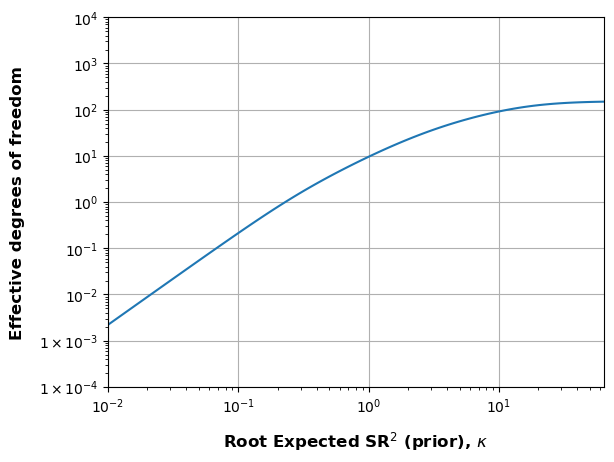

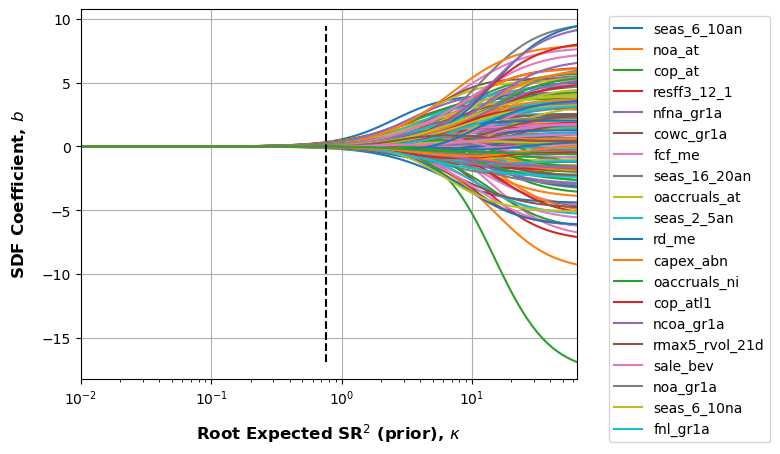

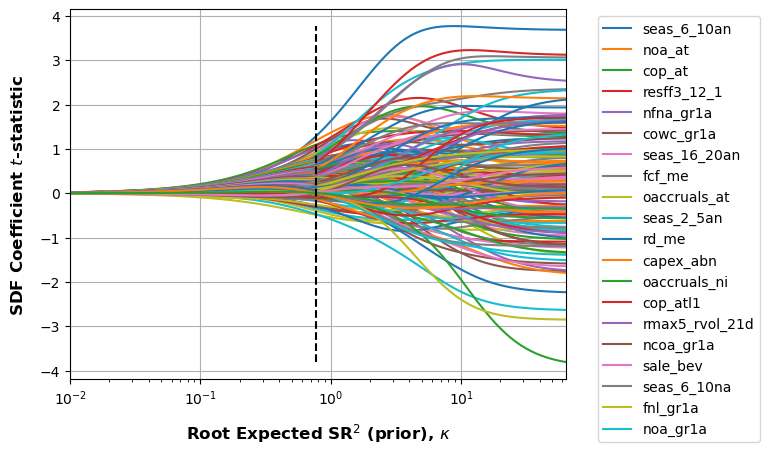

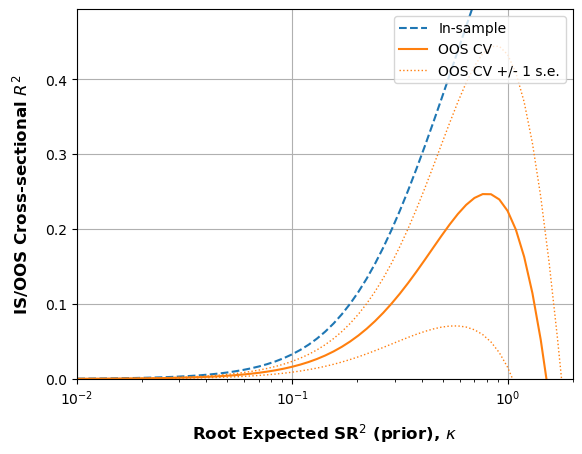

In [321]:
test = SCS_L2est(daily_date_series,df_daily_squeezed,spx_daily_ret_squeezed,365, daily_unique_values, {})

# Dual-Penalty

In [ ]:
train_size = int(len(df_daily) * 0.8)

x_train, x_test = df_daily[:train_size], df_daily[train_size:]
y_train, y_test = spx_daily_ret[:train_size], spx_daily_ret[train_size:]
freq = 252

demarket_train = demarket(x_train,y_train)
demarket_train = demarket_train[0]

demarket_test = demarket(x_test,y_test)
demarket_test = demarket_test[0]
sigma_train = regcov(demarket_train)*freq
mu_train = np.mean(demarket_train, axis=0)*freq
sigma_train_inv = np.linalg.pinv(sigma_train)
T,n = x_train.shape



sparsity_levels = np.linspace(0.01, 153, 153)  
#sparsity_levels = np.unique(np.round(sparsity_levels).astype(int))



"""""
def LARSEN(X, y, sparsity_levels):
    coefs = []
    x_inv = np.linalg.pinv(X)

    for s in sparsity_levels:
        lars = Lars(n_nonzero_coefs=s, normalize=False)
        lars.fit(x_inv, y)
        coefs.append(lars.coef_)

    
    coefs = pd.DataFrame(coefs, index=sparsity_levels)
  
    return coefs
"""""

alpha_levels = np.logspace(-6, 1, 153)

def LASSOLARSEN(X, y, alpha_levels):
    coefs = []
    
    for a in alpha_levels:
        lars = LassoLars(alpha=a)
        lars.fit(X, y)
        coefs.append(lars.coef_)
    
    return pd.DataFrame(coefs, index=alpha_levels)


def cross_validate_LASSOLARSEN(X_dm, k_folds, sparsity_levels, sigma_lars, mu_lars, freq=252):
    """
    X_dm: full de-marketed data, shape (T, n)
    k_folds: number of folds
    sparsity_levels: array-like of integer sparsities for LARS
    freq: optional frequency scaling (default 252)
    """
    # Convert to numpy if needed
    if isinstance(X_dm, pd.DataFrame) or isinstance(X_dm, pd.Series):
        X_dm = X_dm.to_numpy()
    
    T, n = X_dm.shape
    num_sparsities = len(sparsity_levels)
    
    coefs_cv = np.zeros((num_sparsities, n, k_folds))
    R2_cv = np.zeros((num_sparsities, k_folds))
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_dm)):
        X_train = X_dm[train_idx]
        
        # Compute fold-specific mu and sigma from the training data
        mu_train = np.mean(X_train, axis=0) * freq           # shape (n,)
        sigma_train = np.cov(X_train, rowvar=False) * freq   # shape (n, n)
        
        # Fit LARSEN on the training subset
        fold_coefs = LASSOLARSEN(sigma_train, mu_train, sparsity_levels)
        
        for i, s in enumerate(sparsity_levels):
            b = fold_coefs.loc[s].values  # shape (n,)
            coefs_cv[i, :, fold_idx] = b
            
            # Calculate R2 using fold-specific mu and sigma
            residual = mu_lars - sigma_lars @ b
            R2_cv[i, fold_idx] = 1.0 - (residual @ residual.T) / (mu_lars @ mu_lars.T)
    
    # For each sparsity level, pick the highest R2 across folds
    R2_max = np.max(R2_cv, axis=1)
    
    return coefs_cv, R2_cv, R2_max





In [322]:

coef_test, R2_cv_test, R2_max_test = cross_validate_LASSOLARSEN(demarket_train,3,alpha_levels,sigma_train, mu_train, 252)

In [ ]:
coef_test.shape

(153, 153, 3)

In [328]:
R2_cv_test.shape

(153, 3)

# Old try

In [ ]:


 

def elastic_net_sdf_cd(df_factors, gamma1, gamma2, max_iter=1000, tol=1e-6):
    """
    Solve the dual-penalty SDF estimation problem via coordinate descent:
         min_b (mu - Sigma b)^T Sigma^{-1} (mu - Sigma b)
               + gamma2 * ||b||^2
               + gamma1 * ||b||_1

    Accepts a DataFrame of factor returns and retains the column labels,
    but uses the numeric .values for computations.
    """
    # 1. Store column names for reference
    factor_names = df_factors.columns

    # 2. Convert to NumPy array
    F = df_factors.values
    T, H = F.shape

    # 3. Compute sample mean and covariance
    mu_hat = F.mean(axis=0)
    Sigma_hat = regcov(F)

    # 4. Invert or pseudo-invert Sigma
    try:
        Sigma_inv = np.linalg.inv(Sigma_hat)
    except np.linalg.LinAlgError:
        Sigma_inv = np.linalg.pinv(Sigma_hat)

    # 5. Initialize coefficient vector
    b = np.zeros(H)

    for _iter in range(max_iter):
        b_old = b.copy()

        for j in range(H):
            # Gradient from HJ-distance part
            G = Sigma_inv.dot(mu_hat - Sigma_hat.dot(b))
            grad_j_HJ = -2.0 * Sigma_hat[:, j].dot(G)

            # Gradient from L2
            grad_j_L2 = 2.0 * gamma2 * b[j]

            # Total gradient (ignoring L1 subgradient)
            grad_j = grad_j_HJ + grad_j_L2

            # Approximate Hessian for j
            hess_j = 2.0*(Sigma_hat[j, j] * Sigma_inv[j, j]) + 2.0*gamma2

            # Unconstrained update
            b_j_unconstr = b[j] - (1.0 / hess_j) * grad_j

            # Soft-threshold for L1
            thresh = gamma1 / hess_j
            if b_j_unconstr > thresh:
                b[j] = b_j_unconstr - thresh
            elif b_j_unconstr < -thresh:
                b[j] = b_j_unconstr + thresh
            else:
                b[j] = 0.0

        # Convergence check
        if np.linalg.norm(b - b_old) < tol:
            break

    # 6. Return both the numeric coefficients and the factor names
    return pd.Series(b, index=factor_names, name='SDF Coefficients')


In [123]:

# example grids (expand or shrink as needed)
gamma1_range = np.logspace(-5, 10, 25)  # e.g. [0.001, 0.01, 0.1, 1.0, 10.0]
gamma2_range = np.logspace(-5, 10, 25)

"kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)"
lambda_kappa  = lambda kappa, T, X, freq: freq * np.trace(X) / T / (kappa **2)

gamma2_range = np.array([lambda_kappa(kappa,T,sigma_train,252) for kappa in gamma2_range])



results = []


for gamma1 in gamma1_range:
    for gamma2 in gamma2_range:
        
        coef_series = elastic_net_sdf_cd(demarket_train, gamma1, gamma2)
        
        
        result_dict = {'gamma1': gamma1, 'gamma2': gamma2}
        
        result_dict.update(coef_series.to_dict())
        
        
        results.append(result_dict)


L1L2_coef = pd.DataFrame(results)

L1L2_coef_no_gamma = L1L2_coef.iloc[:, 2:]


r2_list = []


for idx, row in L1L2_coef_no_gamma.iterrows():
    
    b = row.values
    
    r2 = cs_r2_metric(demarket_test, b)
    r2_list.append(r2)


R_2_oos_values = pd.DataFrame({'R2': r2_list}, index=L1L2_coef_no_gamma.index)

heatmap = R_2_oos_values["R2"]
heatmap["gamma1"] = L1L2_coef["gamma1"].values
heatmap["gamma2"] = L1L2_coef["gamma2"].values


# Extract the columns as NumPy arrays
x = heatmap["gamma2"].values
y = heatmap["gamma1"].values
z = heatmap['R2'].values

# Create a triangulation for contour plots
triang = tri.Triangulation(x, y)

# Choose however many contour levels you want
levels = np.linspace(z.min(), z.max(), 100)

# Create the figure
plt.figure(figsize=(7, 6))

# Filled contour plot (the "heatmap")
contour_filled = plt.tricontourf(triang, z, levels=levels, cmap='viridis')

# Optionally, add contour lines on top (dotted lines)
contour_lines = plt.tricontour(
    triang, z, levels=levels[::100],  # e.g. every 5th level
    colors='black', linestyles=':', linewidths=0.5
)

# Set log scales if desired
plt.xscale('log')
#plt.yscale('log')

# Label axes
plt.xlabel(r'Root Expected SR$^2$ (prior), $\kappa$')
plt.ylabel('Number of Non-Zero Coefficients')

# Add a colorbar for R^2
cbar = plt.colorbar(contour_filled)
cbar.set_label(r'$R^2$')

plt.title(r'Contour Plot of $R^2$ vs. $\kappa$ and NonZero_Count')
plt.tight_layout()

#ax.set_yscale('log')  # if log scale is desired
#ax.set_ylim(y.min(), y.max())  # specify whatever makes sense for your data
plt.show()




AttributeError: 'numpy.ndarray' object has no attribute 'values'

C:\Users\ulrik\AppData\Local\Temp\ipykernel_16040\3265226529.py:24: UserWarning: No contour levels were found within the data range.
  contour_lines = plt.tricontour(


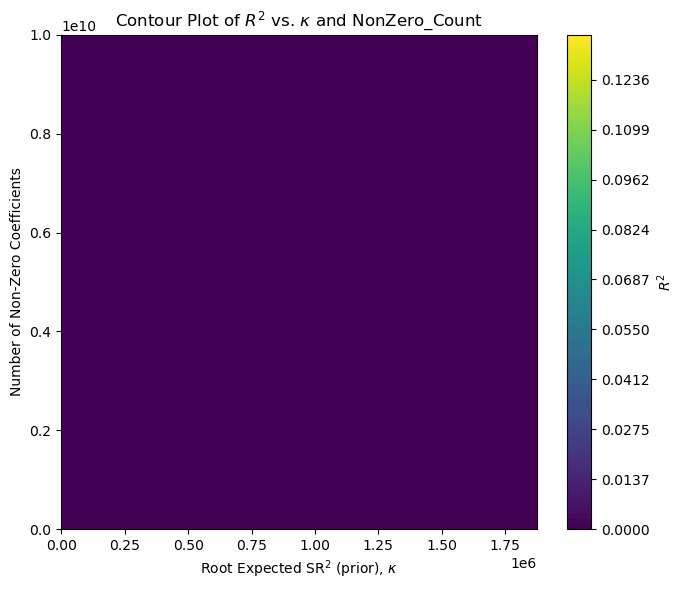

In [139]:
heatmap = R_2_oos_values.copy()
heatmap["gamma1"] = L1L2_coef["gamma1"].values
heatmap["gamma2"] = L1L2_coef["gamma2"].values


# Extract the columns as NumPy arrays
x = heatmap["gamma2"]
y = heatmap["gamma1"]
z = heatmap['R2']

# Create a triangulation for contour plots
triang = tri.Triangulation(x, y)

# Choose however many contour levels you want
levels = np.linspace(z.min(), z.max(), 100)

# Create the figure
plt.figure(figsize=(7, 6))

# Filled contour plot (the "heatmap")
contour_filled = plt.tricontourf(triang, z, levels=levels, cmap='viridis')

# Optionally, add contour lines on top (dotted lines)
contour_lines = plt.tricontour(
    triang, z, levels=levels[::100],  # e.g. every 5th level
    colors='black', linestyles=':', linewidths=0.5
)


# Label axes
plt.xlabel(r'Root Expected SR$^2$ (prior), $\kappa$')
plt.ylabel('Number of Non-Zero Coefficients')

# Add a colorbar for R^2
cbar = plt.colorbar(contour_filled)
cbar.set_label(r'$R^2$')

plt.title(r'Contour Plot of $R^2$ vs. $\kappa$ and NonZero_Count')
plt.tight_layout()

#ax.set_yscale('log')  # if log scale is desired
#ax.set_ylim(y.min(), y.max())  # specify whatever makes sense for your data
plt.show()

# PC

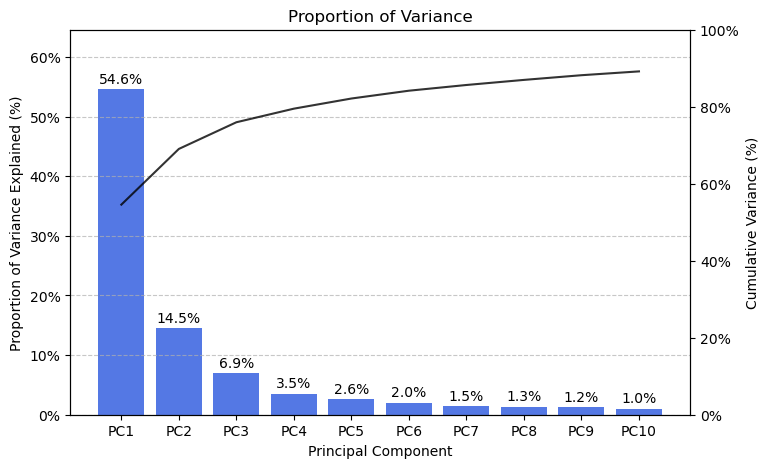

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA without standardization
pca = PCA()
pca.fit(df_wide)

# Get explained variance ratio for the first 10 components
explained_variance_ratio = pca.explained_variance_ratio_[:10]
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar chart for individual variance explained
bars = ax1.bar(range(1, 11), explained_variance_ratio * 100, color="royalblue", alpha=0.9)

# Annotate bars with one decimal place
for bar, value in zip(bars, explained_variance_ratio * 100):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{value:.1f}%", ha="center", fontsize=10)

# Line plot for cumulative variance (black line)
ax2 = ax1.twinx()
ax2.plot(range(1, 11), cumulative_variance * 100, color="black", linestyle="-", alpha=0.8)

# Labels
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Proportion of Variance Explained (%)")
ax2.set_ylabel("Cumulative Variance (%)")
ax1.set_title("Proportion of Variance")

# X-axis ticks
ax1.set_xticks(range(1, 11))
ax1.set_xticklabels([f"PC{i}" for i in range(1, 11)])

# Grid and limits
ax1.set_ylim(0, max(explained_variance_ratio * 100) + 10)
ax2.set_ylim(0, 100)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y)}%"))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y)}%"))
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

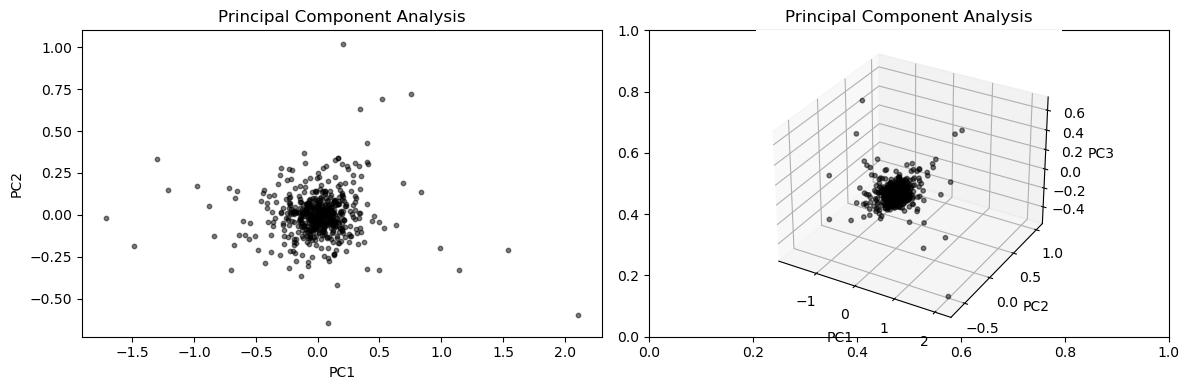

In [16]:
# Apply PCA
pca = PCA(n_components=3)
pc_scores = pca.fit_transform(df_wide)  # Get transformed principal components

# Create figure for 2D and 3D scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': None})

# --- 2D Scatter Plot (PC1 vs. PC2) ---
axes[0].scatter(pc_scores[:, 0], pc_scores[:, 1], color='black', alpha=0.5, edgecolors='black', s=10)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("Principal Component Analysis")

# --- 3D Scatter Plot (PC1 vs. PC2 vs. PC3) ---
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(pc_scores[:, 0], pc_scores[:, 1], pc_scores[:, 2], color='black', alpha=0.5, edgecolors='black', s=10)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Principal Component Analysis")

# Show plots
plt.tight_layout()
plt.show()

In [17]:
X_test = df_wide.values
U, S, Vt = np.linalg.svd(X_test)

Vt_df = pd.DataFrame(Vt, index=[f'V{i+1}' for i in range(Vt.shape[0])], columns=df_wide.columns)

In [18]:
print(df_wide.shape)

print(Vt_df.shape)

(528, 153)
(153, 153)


In [19]:
# Convert DataFrames to NumPy arrays (if they aren’t already)
P_t = np.dot(df_wide, Vt_df)

# Convert back to DataFrame for better readability
df_pca = pd.DataFrame(P_t, index=df_wide.index, columns=Vt_df.columns)


In [20]:
# Perform PCA directly on the raw data
#pca = PCA()
#principal_components = pca.fit_transform(df_wide)

# Convert to DataFrame
#df_pca = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
# Convert DataFrames to NumPy arrays (if they aren’t already)
P_t = np.dot(df_wide, Vt_df)

# Convert back to DataFrame for better readability
df_pca = pd.DataFrame(P_t, index=df_wide.index, columns=Vt_df.columns)
# Choice of two data set. 

#1 factor returns
df_wide_train_pca = df_pca.iloc[:369, :]
df_wide_test_pca = df_pca.iloc[370:, :]



# List to hold results for each gamma1, gamma2 pair
results_pca = []

# Loop over each gamma1 and gamma2 combination
for gamma1 in gamma1_range:
    for gamma2 in gamma2_range:
        # Estimate the SDF coefficients for the given pair of gammas
        coef_series_pca = elastic_net_sdf_cd(df_wide_train_pca, gamma1, gamma2)
        
        # Create a dictionary for the current pair:
        # Start with gamma values
        result_dict_pca = {'gamma1': gamma1, 'gamma2': gamma2}
        # Add all the coefficient estimates (the series keys are the factor names)
        result_dict_pca.update(coef_series_pca.to_dict())
        
        # Append the dictionary to our results list
        results_pca.append(result_dict_pca)

# Convert the list of dictionaries into a DataFrame
L1L2_coef_pca = pd.DataFrame(results_pca)

L1L2_coef_no_gamma_pca = L1L2_coef_pca.iloc[:, 2:]

# Initialize a list to collect R^2 values
r2_list_pca = []

# Iterate over each row of L1L2_coef_no_gamma
for idx, row in L1L2_coef_no_gamma_pca.iterrows():
    # Convert the row to a numpy array (this is our beta coefficient vector)
    b_pca = row.values
    # Compute the R^2 for this set of coefficients using the hold-out set F_holdout
    r2_pca = cs_r2_metric(df_wide_test_pca, b_pca)
    r2_list_pca.append(r2_pca)

# Create a DataFrame to store the results, preserving the index of L1L2_coef_no_gamma
R_2_oos_values_pca = pd.DataFrame({'R2': r2_list_pca}, index=L1L2_coef_no_gamma_pca.index)

# Display the new DataFrame
#print(R_2_oos_values)

L1L2_coef_no_gamma_mean_pca = np.mean(L1L2_coef_no_gamma_pca, axis=0)

gamma_2_values_pca = L1L2_coef_pca['gamma2']


C:\Users\ulrik\AppData\Local\Temp\ipykernel_18020\3921338806.py:43: UserWarning: No contour levels were found within the data range.
  contour_lines_pca = plt.tricontour(


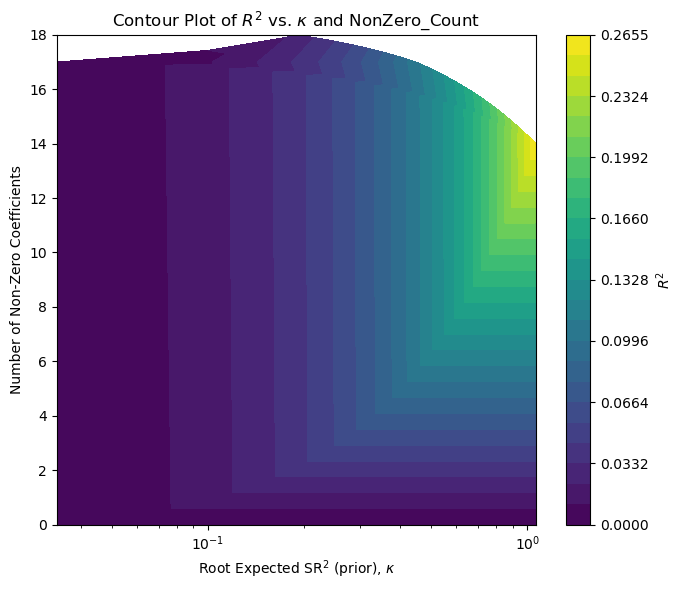

In [21]:
sigma_kappa_pca = regcov(df_pca)
mu_kappa_pca = np.mean(df_pca, axis=0)




# Compute kappa2 penalty for each gamma in the range
results_pca = [kappa2penalty(gamma, 153, 12, sigma_kappa_pca) for gamma in gamma_2_values_pca]

# Store in a DataFrame
df_results_pca = pd.DataFrame({'gamma 2': gamma_2_values_pca, 'kappa': results_pca})

heatmap_pca = pd.DataFrame({
    'NonZero_Count': (L1L2_coef_no_gamma_pca != 0).sum(axis=1)
})

heatmap_pca['R_2'] = R_2_oos_values_pca

heatmap_pca['kappa'] = df_results_pca['kappa']



# Extract the columns as NumPy arrays
x_pca = heatmap_pca['kappa'].values
y_pca = heatmap_pca['NonZero_Count'].values
z_pca = heatmap_pca['R_2'].values



# Create a triangulation for contour plots
triang_pca = tri.Triangulation(x_pca, y_pca)

# Choose however many contour levels you want
levels_pca = np.linspace(z_pca.min(), z_pca.max(), 25)

# Create the figure
plt.figure(figsize=(7, 6))

# Filled contour plot (the "heatmap")
contour_filled_pca = plt.tricontourf(triang_pca, z_pca, levels=levels_pca, cmap='viridis')

# Optionally, add contour lines on top (dotted lines)
contour_lines_pca = plt.tricontour(
    triang_pca, z_pca, levels=levels_pca[::100],  # e.g. every 5th level
    colors='black', linestyles=':', linewidths=0.5
)

# Set log scales if desired
plt.xscale('log')
#plt.yscale('log')

# Label axes
plt.xlabel(r'Root Expected SR$^2$ (prior), $\kappa$')
plt.ylabel('Number of Non-Zero Coefficients')

# Add a colorbar for R^2
cbar_pca = plt.colorbar(contour_filled_pca)
cbar_pca.set_label(r'$R^2$')

plt.title(r'Contour Plot of $R^2$ vs. $\kappa$ and NonZero_Count')
plt.tight_layout()

ax.set_yscale('log')  # if log scale is desired
ax.set_ylim(y_pca.min(), y_pca.max())  # specify whatever makes sense for your data
plt.show()




l1 ratio = 0 -> L2 (ridge)


l1 ratio = 1 -> L2 (lasso)
 

# Portfolio optimization 

In [24]:
L2_weights = test['bL2']
oos_test_data = df_daily_squeezed.iloc[7500:]

SPX_port = spx_daily_ret_squeezed[7500:]
multiplication_test = L2_weights @ oos_test_data.T

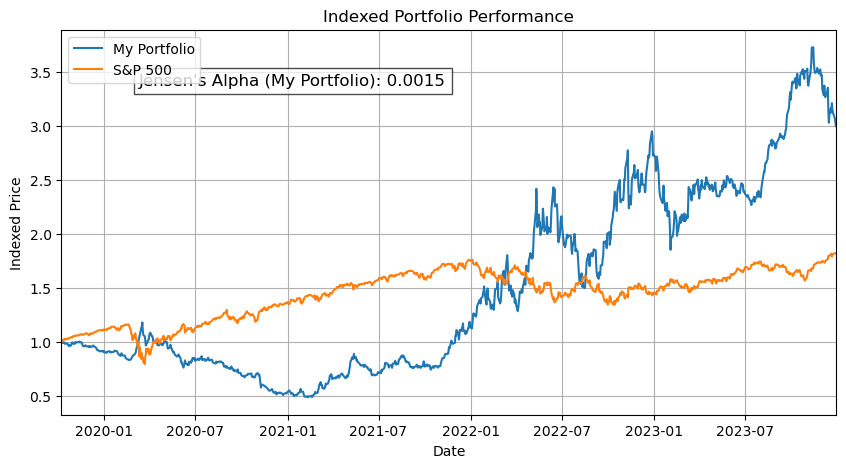

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_indexed_with_jensens_alpha(series_dict, risk_free_rate=0.0, title="Indexed Portfolio Performance"):
    """
    Plots multiple indexed price series from log returns, ensuring all start at 1.
    Also calculates and displays Jensen's Alpha for "My Portfolio" using "S&P 500" as the benchmark.

    Parameters:
    - series_dict (dict): Dictionary where keys are labels (str) and values are Pandas Series of log returns.
    - risk_free_rate (float, optional): Risk-free rate used in Jensen's Alpha calculation. Default is 0.
    - title (str, optional): Title of the plot.

    Returns:
    - None (displays the plot and shows Jensen's Alpha for "My Portfolio" on the chart)
    """
    plt.figure(figsize=(10, 5))

    for label, log_returns_series in series_dict.items():
        # Convert log returns to indexed price starting at 1
        indexed_price = np.exp(log_returns_series.cumsum())
        indexed_price /= indexed_price.iloc[0]  # Normalize to start at 1

        # Plot each series
        plt.plot(indexed_price.index, indexed_price, label=label)

    # Calculate Jensen's Alpha only for "My Portfolio" using "S&P 500" as benchmark
    jensens_alpha_text = ""
    if "My Portfolio" in series_dict and "S&P 500" in series_dict:
        R_p = series_dict["My Portfolio"]
        R_m = series_dict["S&P 500"]

        # Compute beta of portfolio w.r.t. market
        beta = np.cov(R_p, R_m)[0, 1] / np.var(R_m)

        # Compute expected return using CAPM formula
        expected_portfolio_return = risk_free_rate + beta * (R_m.mean() - risk_free_rate)

        # Compute Jensen's Alpha
        jensens_alpha = R_p.mean() - expected_portfolio_return
        jensens_alpha_text = f"Jensen's Alpha (My Portfolio): {jensens_alpha:.4f}"

        # Show Jensen's Alpha on the chart
        plt.text(
            x=R_p.index[int(len(R_p) * 0.1)],  # Position it at 10% of the timeline
            y=max(np.exp(R_p.cumsum())) * 0.9,  # Position it 90% of the highest indexed price
            s=jensens_alpha_text,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
        )

    # Formatting
    plt.xlabel("Date")
    plt.ylabel("Indexed Price")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Set x-axis limits to start from the first date in the dataset
    min_date = min(series.index[0] for series in series_dict.values())  # Earliest date
    max_date = max(series.index[-1] for series in series_dict.values())  # Latest date
    plt.xlim([min_date, max_date])

    # Show plot
    plt.show()

# Example usage:
plot_indexed_with_jensens_alpha({"My Portfolio": multiplication_test, "S&P 500": SPX_port})


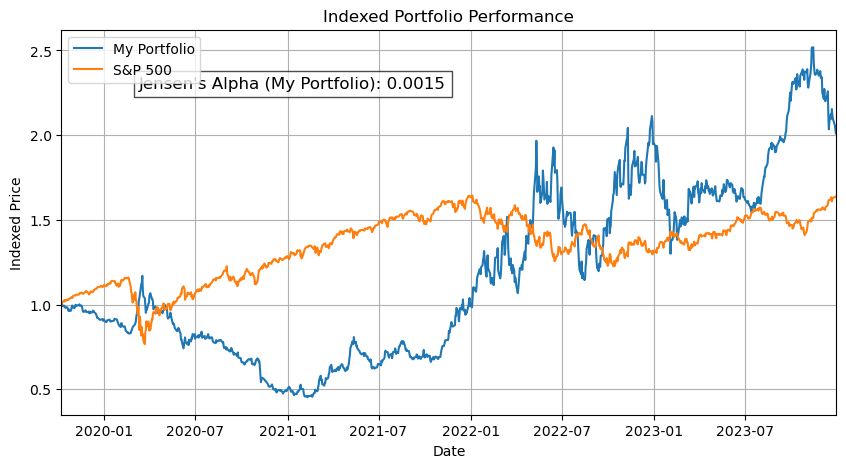

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_indexed_with_jensens_alpha(series_dict, risk_free_rate=0.0, title="Indexed Portfolio Performance"):
    """
    Plots multiple indexed price series from returns, ensuring all start at 1.
    Also calculates and displays Jensen's Alpha for "My Portfolio" using "S&P 500" as the benchmark.

    Parameters:
    - series_dict (dict): Dictionary where keys are labels (str) and values are Pandas Series of returns.
    - risk_free_rate (float, optional): Risk-free rate used in Jensen's Alpha calculation. Default is 0.
    - title (str, optional): Title of the plot.

    Returns:
    - None (displays the plot and shows Jensen's Alpha for "My Portfolio" on the chart)
    """
    plt.figure(figsize=(10, 5))

    for label, returns_series in series_dict.items():
        # Convert returns to indexed price starting at 1
        indexed_price = (1 + returns_series).cumprod()
        indexed_price /= indexed_price.iloc[0]  # Normalize to start at 1

        # Plot each series
        plt.plot(indexed_price.index, indexed_price, label=label)

    # Calculate Jensen's Alpha only for "My Portfolio" using "S&P 500" as benchmark
    jensens_alpha_text = ""
    if "My Portfolio" in series_dict and "S&P 500" in series_dict:
        R_p = series_dict["My Portfolio"]
        R_m = series_dict["S&P 500"]

        # Compute beta of portfolio w.r.t. market
        beta = np.cov(R_p, R_m)[0, 1] / np.var(R_m)

        # Compute expected return using CAPM formula
        expected_portfolio_return = risk_free_rate + beta * (R_m.mean() - risk_free_rate)

        # Compute Jensen's Alpha
        jensens_alpha = R_p.mean() - expected_portfolio_return
        jensens_alpha_text = f"Jensen's Alpha (My Portfolio): {jensens_alpha:.4f}"

        # Show Jensen's Alpha on the chart
        plt.text(
            x=R_p.index[int(len(R_p) * 0.1)],  # Position it at 10% of the timeline
            y=max((1 + R_p).cumprod()) * 0.9,  # Position it 90% of the highest indexed price
            s=jensens_alpha_text,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
        )

    # Formatting
    plt.xlabel("Date")
    plt.ylabel("Indexed Price")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Set x-axis limits to start from the first date in the dataset
    min_date = min(series.index[0] for series in series_dict.values())  # Earliest date
    max_date = max(series.index[-1] for series in series_dict.values())  # Latest date
    plt.xlim([min_date, max_date])

    # Show plot
    plt.show()

# Example usage:
plot_indexed_with_jensens_alpha({"My Portfolio": multiplication_test, "S&P 500": SPX_port})


In [27]:
print(spx_daily_ret.shape)
print(spx_daily_ret_squeezed.shape)

(8564, 1)
(8564,)


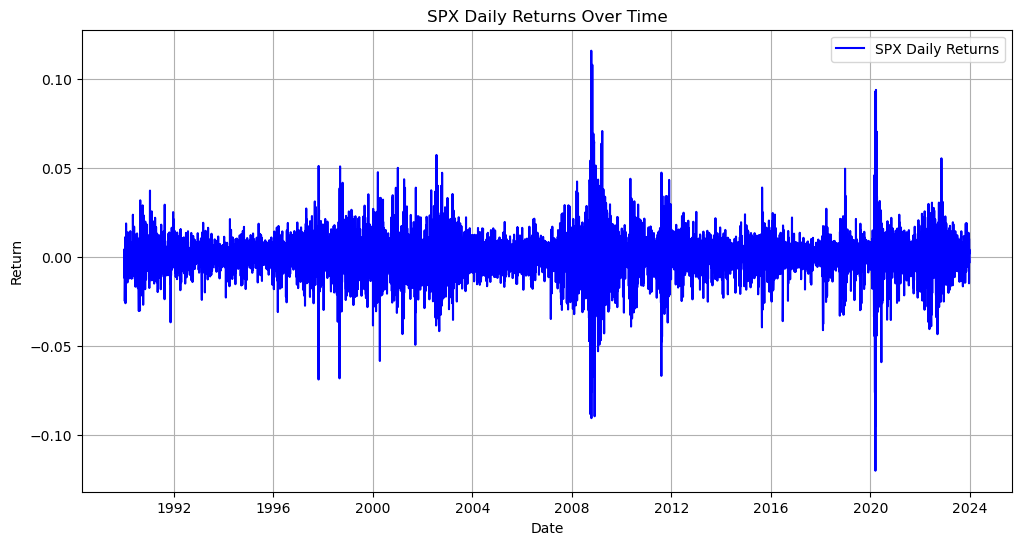

In [28]:
# Plot the time series
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(spx_daily_ret_squeezed, label="SPX Daily Returns", color="blue")

# Formatting
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("SPX Daily Returns Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
